In [1]:
using gmsh

using Gridap, GridapGmsh
using Gridap.Fields, Gridap.Geometry

using Plots

# 1D Stationary
Before going into the transient FEM model, we will first build a basic Gridap model for the stationary case. This will serve as our reference for the steady state that the transient model will tend towards. For the 1D example, we will model a horizontal bar occupying the domain $\Omega = [0, L]$, where $L = 5\,\mathrm{m}$ is the length of the bar. On this domain, we will define the temperature using the heat equation.
$$ \rho c_p \frac{\partial T}{\partial t} + \nabla \cdot \left[ k \nabla T \right] = Q_v \qquad x \in \Omega$$
Initially, we will assume that we have reached steady state, i.e., $\frac{\partial T}{\partial t} = 0$. Additionally, the thermal conductivity $k = 1\,\mathrm{W/(m \cdot K)}$. The differential equation simplifies to
$$ \nabla^2 T = Q_v \qquad x \in \Omega $$
where $Q_v$ is the source heat flux term in $\mathrm{[W/m^3]}$. We impose a Dirichlet condition $T = T_0 = 20\,\mathrm{^\circ C}$ on the right boundary $x = L$, and a Neumann condition $-k \frac{\partial T}{\partial x} = P = 10\,\mathrm{W}$ representing inward heat flux on the left boundary $x = 0$.

## Analytic Solution
For this simple case, we can easily derive the analytic solution by hand. The solution is obtain by integrating the differential equation twice and imposing the boundary conditions.
$$ \frac{\partial^2 T}{\partial x^2} = 0 \implies T(x) = c_1 x + c_2 $$
Using the two boundary conditions $T(x = L) = T_0$ and $T^\prime(x = 0) = P$, we find
\begin{align*}
    T(x) & = -P x + (T_0 + P L) = -10 x + 70 \qquad \mathrm{[^\circ C]} \\
    Q(x) & = -k \cdot -P = 10 \qquad \mathrm{[W]}
\end{align*}

## Weak Form
The weak form to be implemented in Gridap is easily derived by applying integration by parts.
$$ \int_\Omega \nabla^2 T \cdot \phi_k d\Omega = 0 \implies \int_\Omega \nabla T \cdot \nabla \phi_k d\Omega = \oint_{\Gamma_{left}} P \phi_k d\Gamma \qquad 1 \le k \le N $$

## Generate Mesh

In [2]:
T0 = 20.0;    # Ambient temperature [degC]
P  = 10;      # Heat flux into the left side of the bar [W]
L  = 5;       # Length of the bar [m]

lc1 = 0.01;   # Mesh density [m]

In [3]:
gmsh.initialize()

gmsh.model.add("bar_type3")
geo  = gmsh.model.geo;
mesh = gmsh.model.mesh;

# Points
geo.addPoint(0, 0, 0, lc1, 1)
geo.addPoint(L, 0, 0, lc1, 2)

# Lines
geo.addLine(1, 2, 1)

geo.synchronize()

# Physical domains
geo.addPhysicalGroup(0, [1], 1)
geo.addPhysicalGroup(0, [2], 2)
gmsh.model.setPhysicalName(0, 1, "bnd_left")
gmsh.model.setPhysicalName(0, 2, "bnd_right")

geo.addPhysicalGroup(1, [1], 1)
gmsh.model.setPhysicalName(1, 1, "domain")

geo.synchronize()

# Generate mesh
mesh.generate(1);
gmsh.write("geo/bar_type3.msh")

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.00529814s, CPU 0s)
Info    : 501 nodes 502 elements
Info    : Writing 'geo/bar_type3.msh'...
Info    : Done writing 'geo/bar_type3.msh'


## Gridap

In [4]:
# Define Lagrangian reference element
order = 2;
reffe = ReferenceFE(lagrangian, Float64, order)

# Load mesh
model = GmshDiscreteModel("geo/bar_type3.msh")
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)
Γ = BoundaryTriangulation(model, tags = ["bnd_left"]) # Triangulation for Neumann boundary condition
dΓ = Measure(Γ, 2*order)

# Construct Lagrangian test space with dirichlet condition on the right boundary node
V = TestFESpace(model, reffe, dirichlet_tags = ["bnd_right"])
U = TrialFESpace(V, [T0])

Info    : Reading 'geo/bar_type3.msh'...
Info    : 3 entities
Info    : 501 nodes
Info    : 502 elements
Info    : Done reading 'geo/bar_type3.msh'


TrialFESpace()

In [5]:
# Define the weak form (bilinear and linear terms)
a(u,v) = ∫( ∇(u) ⋅ ∇(v) )dΩ
b(v)   = ∫( P * v )dΓ
op = AffineFEOperator(a, b, U, V)

# Solve the linear FE system with LU solver
ls = LUSolver()
solver = LinearFESolver(ls)
uh = solve(solver, op);

# Post-process for the heat flux
Qh = -∇(uh);

In [6]:
writevtk(Ω,"sol/sol_1d_stationary",cellfields=["Th"=>uh,"Qh"=>Qh])

(["sol/sol_1d_stationary.vtu"],)

## Solution

In [20]:
x_int = collect(0:L/100:L)

# Evaluate solutions at interpolation points x_int
coord = [VectorValue(x_) for x_ in x_int];
T = uh(coord);
Q = Qh(coord);
Q = [q[1] for q in Q];

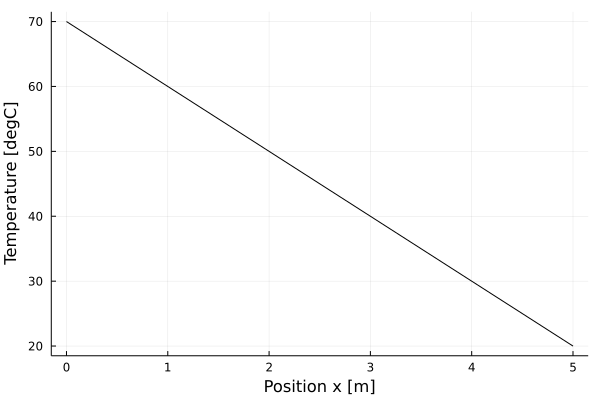

In [23]:
plot(x_int, T, color = :black, legend = false, xlabel = "Position x [m]", ylabel = "Temperature [degC]")

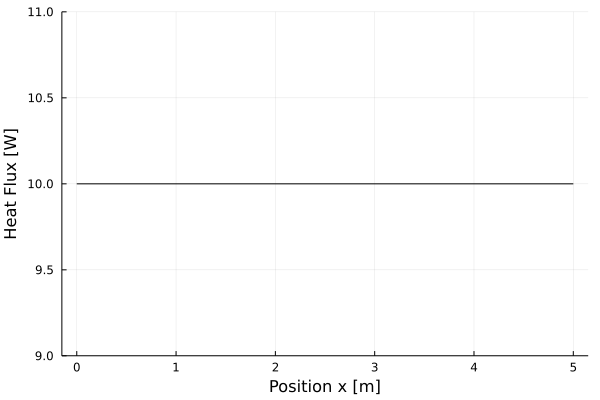

In [32]:
plot(x_int, Q, color = :black, legend = false, xlabel = "Position x [m]", ylabel = "Heat Flux [W]", ylim = (9, 11))

# 1D Transient
Next, we can consider the transient version of this problem, which includes the $\frac{\partial T}{\partial t}$ term:
$$ \frac{\partial T}{\partial t} + \nabla^2 T = 0 $$
where we assume that the thermal capacity $\rho c_p = 1$. The term with the double derivative can be treated the same way as before, using integration by parts. This part corresponds to the stiffness matrix. The time-derivative will result in an additional contribution to the system of equation: the mass matrix.

## Weak Form
We obtain the weak form simply by applying the definition. All terms except the first are well known by now and can be implemented easily.
$$ \int_\Omega \dot{T} \phi_k d\Omega + \int_\Omega \nabla T \cdot \nabla \phi_k d\Omega = \oint_{\Gamma_{left}} P \phi_k d\Gamma \qquad 1 \le k \le N $$

## Treating the Time Derivative

## Gridap

In [33]:
# Define Lagrangian reference element
order = 2;
reffe = ReferenceFE(lagrangian, Float64, order)

# Load mesh
model = GmshDiscreteModel("geo/bar_type3.msh")
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)
Γ = BoundaryTriangulation(model, tags = ["bnd_left"])
dΓ = Measure(Γ, 2*order)

# Construct Lagrangian test space
V = TestFESpace(model, reffe, dirichlet_tags = ["bnd_right"])

# Build a transient trial space with Dirichlet conditions
g(x, t::Real) = T0 * (x[1] == L);
g(t::Real) = x -> g(x,t)
U  = TransientTrialFESpace(V, g)

Pf(t) = P * (t > 1);

Info    : Reading 'geo/bar_type3.msh'...
Info    : 3 entities
Info    : 501 nodes
Info    : 502 elements
Info    : Done reading 'geo/bar_type3.msh'


In [34]:
# Define the weak form; note the additional term for the mass matrix m(t,u,v)
m(t,u,v) = ∫( v * u )dΩ
a(t,u,v) = ∫( ∇(u) ⋅ ∇(v) )dΩ
b(t,v) = ∫( 0 * v )dΩ + ∫( Pf(t) * v )dΓ

op = TransientAffineFEOperator(m, a, b, U, V)

TransientFEOperatorFromWeakForm()

In [35]:
# Solve each time step using a linear LU solver
solver = LUSolver()

# Discretize the ODE using the theta method
Δt = 0.25;   # Time step
t0 = 0.0;    # Starting time
T = 50;      # Ending time

θ = 1        # Parameter for theta method
ode_solver = ThetaMethod(solver, Δt, θ)

# Solve the ODE with T0 as initial condition at t = 0.0
u0 = interpolate_everywhere(T0, U(0.0))
uht = solve(ode_solver, op, u0, t0, T)

Gridap.ODEs.TransientFETools.TransientFESolution(GenericODESolution(), TransientTrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}, TrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}}}(UnconstrainedFESpace(), g, TrialFESpace()))

In [13]:
createpvd("sol/sol_1d_transient") do pvd
    for (uh,t) in uht
        Qh = -∇(uh);
        
        pvd[t] = createvtk(Ω, "sol/sol_1d_transient_$t" * ".vtu", cellfields=["Th" => uh, "Qh" => Qh])
    end
end

201-element Vector{String}:
 "sol/sol_1d_transient.pvd"
 "sol/sol_1d_transient_0.25.vtu"
 "sol/sol_1d_transient_0.5.vtu"
 "sol/sol_1d_transient_0.75.vtu"
 "sol/sol_1d_transient_1.0.vtu"
 "sol/sol_1d_transient_1.25.vtu"
 "sol/sol_1d_transient_1.5.vtu"
 "sol/sol_1d_transient_1.75.vtu"
 "sol/sol_1d_transient_2.0.vtu"
 "sol/sol_1d_transient_2.25.vtu"
 "sol/sol_1d_transient_2.5.vtu"
 "sol/sol_1d_transient_2.75.vtu"
 "sol/sol_1d_transient_3.0.vtu"
 ⋮
 "sol/sol_1d_transient_47.25.vtu"
 "sol/sol_1d_transient_47.5.vtu"
 "sol/sol_1d_transient_47.75.vtu"
 "sol/sol_1d_transient_48.0.vtu"
 "sol/sol_1d_transient_48.25.vtu"
 "sol/sol_1d_transient_48.5.vtu"
 "sol/sol_1d_transient_48.75.vtu"
 "sol/sol_1d_transient_49.0.vtu"
 "sol/sol_1d_transient_49.25.vtu"
 "sol/sol_1d_transient_49.5.vtu"
 "sol/sol_1d_transient_49.75.vtu"
 "sol/sol_1d_transient_50.0.vtu"

# 2D Transient

In [136]:
# Define Lagrangian reference element
order = 2;
reffe = ReferenceFE(lagrangian, Float64, order)

# Load mesh
model = GmshDiscreteModel("geo/coupled_inductor.msh")
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)
#Γ = BoundaryTriangulation(model, tags = ["bnd_left"])
#dΓ = Measure(Γ, 2*order)

# Construct Lagrangian test space
V = TestFESpace(model, reffe, dirichlet_tags = ["dirichlet"])

# Build a transient trial space with Dirichlet conditions
g(x, t::Real) = 0;
g(t::Real) = x -> g(x,t)
U  = TransientTrialFESpace(V, g)

Info    : Reading 'geo/coupled_inductor.msh'...
Info    : 47 entities
Info    : 6957 nodes
Info    : 13912 elements
Info    : Done reading 'geo/coupled_inductor.msh'


TransientTrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}, TrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}}}(UnconstrainedFESpace(), g, TrialFESpace())

In [159]:
labels = get_face_labeling(model)
dimension = num_cell_dims(model)
tags = get_face_tag(labels, dimension)

const tag_air = get_tag_from_name(labels, "Air")
const tag_core = get_tag_from_name(labels, "Core")
const tag_wdg_left = get_tag_from_name(labels, "Winding Left")
const tag_wdg_right = get_tag_from_name(labels, "Winding Right")

function rcp(tag)
    if(tag == tag_air)
        return 1.225 * 700;
    elseif(tag == tag_core)
        return 5.0e3 * 750;
    elseif(tag == tag_wdg_left || tag == tag_wdg_right)
        return 8.96e3 * 1.46e3;
    else
        error("rho * cp not defined for tag {$tag}")
        return -1;
    end
end

function k(tag)
    if(tag == tag_air)
        return 0.025;
    elseif(tag == tag_core)
        return 4;
    elseif(tag == tag_wdg_left || tag == tag_wdg_right)
        return 398;
    else
        error("k not defined for tag {$tag}")
        return -1;
    end
end

function Psource(tag)
    if(tag == tag_air)
        return 0.0;
    elseif(tag == tag_core)
        return 50.0 / 190e-6;
    elseif(tag == tag_wdg_left || tag == tag_wdg_right)
        return 50.0 / 60e-6;
    else
        error("Psource not defined for tag {$tag}")
        return -1;
    end
end

Pf(t) = 0;

τ = CellField(tags, Ω);

In [160]:
m(t,u,v) = ∫( (rcp ∘ τ) * v * u )dΩ
a(t,u,v) = ∫( (k ∘ τ) * ∇(u) ⋅ ∇(v) )dΩ
b(t,v) = ∫( (Psource ∘ τ) * v )dΩ; #+ ∫( Pf(t) * v )dΓ

op = TransientAffineFEOperator(m, a, b, U, V)

TransientFEOperatorFromWeakForm()

In [161]:
solver = LUSolver()

Δt = 2;
θ = 0.75
ode_solver = ThetaMethod(solver, Δt, θ)

u0 = interpolate_everywhere(0, U(0.0))
t0 = 0.0
T = 200;

uht = solve(ode_solver, op, u0, t0, T)

Gridap.ODEs.TransientFETools.TransientFESolution(GenericODESolution(), TransientTrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}, TrialFESpace{Gridap.FESpaces.UnconstrainedFESpace{Vector{Float64}, Nothing}}}(UnconstrainedFESpace(), g, TrialFESpace()))

In [162]:
createpvd("sol/sol_2d_transient") do pvd
    for (uh,t) in uht
        Qh = -∇(uh);
        
        pvd[t] = createvtk(Ω, "sol/sol_2d_transient_$t" * ".vtu", cellfields=["Th" => uh, "Qh" => Qh])
    end
end

101-element Vector{String}:
 "sol/sol_2d_transient.pvd"
 "sol/sol_2d_transient_2.0.vtu"
 "sol/sol_2d_transient_4.0.vtu"
 "sol/sol_2d_transient_6.0.vtu"
 "sol/sol_2d_transient_8.0.vtu"
 "sol/sol_2d_transient_10.0.vtu"
 "sol/sol_2d_transient_12.0.vtu"
 "sol/sol_2d_transient_14.0.vtu"
 "sol/sol_2d_transient_16.0.vtu"
 "sol/sol_2d_transient_18.0.vtu"
 "sol/sol_2d_transient_20.0.vtu"
 "sol/sol_2d_transient_22.0.vtu"
 "sol/sol_2d_transient_24.0.vtu"
 ⋮
 "sol/sol_2d_transient_178.0.vtu"
 "sol/sol_2d_transient_180.0.vtu"
 "sol/sol_2d_transient_182.0.vtu"
 "sol/sol_2d_transient_184.0.vtu"
 "sol/sol_2d_transient_186.0.vtu"
 "sol/sol_2d_transient_188.0.vtu"
 "sol/sol_2d_transient_190.0.vtu"
 "sol/sol_2d_transient_192.0.vtu"
 "sol/sol_2d_transient_194.0.vtu"
 "sol/sol_2d_transient_196.0.vtu"
 "sol/sol_2d_transient_198.0.vtu"
 "sol/sol_2d_transient_200.0.vtu"